In [7]:
import numpy as np
import os
import pandas as pd
import soundfile as sf

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib.patches import Rectangle

import scipy.io.wavfile as wav
import datetime as dt
from pathlib import Path

from torch import multiprocessing
from tqdm import tqdm

In [8]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

In [9]:
from src.cfg import get_config
from src.pipeline import pipeline

In [10]:
def subsample_frompath(audio_filepath, output_dir, percent_on, offset):

    audio = sf.SoundFile(audio_filepath)

    sr = audio.samplerate
    audio_length = audio.frames 
    frames_on = percent_on * audio_length
    
    audio.seek(sr*offset)
    sub_audio = audio.read(np.round(frames_on).astype('int32'), dtype='int16')

    op_file = os.path.basename(audio_filepath.name).replace(" ", "_")
    op_file = f"{op_file[:-4]}__{(percent_on):.0%}DUTYCYCLE_{offset:.0f}secOFFSET.WAV"

    sf.write(os.path.join(output_dir, op_file), sub_audio, sr, subtype='PCM_16') 

    return sr, sub_audio

def plt_msds(filename, audio, fs, reftimes, times, p_on=1):
    ## Make sure given times are within audio file
    #  If times extend beyond file, reduce times to file boundaries
    times[times < 0] = 0
    times[times > len(audio)/fs] = int(len(audio)/fs)
    audio = audio[times[0]*fs:times[1]*fs]

    ## Strip the datetime for year, month, date, and hour from filename
    file_dt = dt.datetime.strptime(filename[:15], '%Y%m%d_%H%M%S')

    ## Only find numPoints amount of labels from all available seconds
    numPoints = 11
    seconds = np.arange(fs*times[0], fs*times[1]+1)/fs
    idx = np.round(np.linspace(0, len(seconds)-1, numPoints)).astype('int32')
    sec_labels = reftimes[0] + seconds[idx]

    ## Calculate Time Labels for X-Axis using Datetime objects as Strings
    time_labels = np.array([dt.datetime(year=file_dt.year, month=file_dt.month, 
                                        day=file_dt.day, hour=file_dt.hour, 
                                        minute=file_dt.minute + int(sec/60), second=int(sec%60), 
                                        microsecond=np.round(1e6*(sec%60-int(sec%60))).astype('int32')).strftime('%T.%f')[:-4] 
                                        for sec in sec_labels])

    ## Find x-axis tick locations from all available seconds and convert to samples
    s_ticks = seconds[idx]-times[0]
    x_ticks = s_ticks*fs

    ## Calculate detection parameters from msds output to use for drawing rectangles
    xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels = get_msds_params(filename, reftimes+times)

    ## Create figure
    plt.figure(figsize=(12, 9))

    ## Plotting Audio Signal
    plt.subplot(311)
    plt.title(f"{100*p_on}% Duty Cycle")
    plt.plot(audio)
    plt.ylabel("Amplitude (kU)")
    plt.xlim((0, s_ticks[-1]*fs))
    plt.xticks(ticks=x_ticks, labels=time_labels)
    amp_ticks = plt.yticks()[0]
    amp_ticks = np.insert(amp_ticks, 0, -1*amp_ticks[-1])
    plt.yticks(ticks=amp_ticks, labels=(amp_ticks/1000).astype('int16'))
    plt.ylim((amp_ticks[0], amp_ticks[-1]))
    plt.grid(which="both")

    ## Plotting Spectrogram of Audio Signal
    plt.subplot(312)
    plt.specgram(audio, Fs=fs, cmap='ocean')
    plt.ylabel("Frequency (kHz)")
    plt.xticks(ticks=s_ticks, labels=time_labels)
    ## Find y-axis tick locations from specgram-calculated locations and keep limit just in case
    f_ticks = plt.yticks()[0]
    f_ticks = f_ticks[f_ticks <= fs/2]
    plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))

    ## Plotting Spectrogram with MSDS outputs overlayed
    plt.subplot(313)
    plt.specgram(audio, Fs=fs, cmap='ocean')
    plt.xlabel("Time (HH:MM:SS)")
    plt.ylabel("Frequency (kHz)")
    plt.xticks(ticks=s_ticks, labels=time_labels)
    plt.yticks(ticks=f_ticks, labels=(f_ticks/1000).astype('int16'))
    ax = plt.gca()
    for i in range(len(xs_inds)):
        rect = Rectangle((xs_inds[i], xs_freqs[i]), 
                        x_durations[i], x_bandwidths[i], 
                        linewidth=1, edgecolor='y', facecolor='none')
        if (np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32') < len(audio) and audio[np.floor((xs_inds[i]+x_durations[i])*fs).astype('int32')] != 0):
            ax.add_patch(rect)
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

def get_msds_params(filename:str, times):
    csv_file = f'../output_dir/BatDetectorMSDS-{filename}.csv'
    df = pd.read_csv(csv_file)
    s_times = df['start_time']
    e_times = df['end_time']
    s_freqs = df['low_freq']
    e_freqs = df['high_freq']
    det_labels = df['event'].values
    xs_inds = s_times[np.logical_and(s_times > times[0], e_times < times[1])].values - times[0]
    xe_inds = e_times[np.logical_and(s_times > times[0], e_times < times[1])].values - times[0]
    xs_freqs = s_freqs[np.logical_and(s_times > times[0], e_times < times[1])].values
    xe_freqs = e_freqs[np.logical_and(s_times > times[0], e_times < times[1])].values
    x_durations = xe_inds - xs_inds
    x_bandwidths = xe_freqs - xs_freqs

    return xs_inds, xs_freqs, x_durations, x_bandwidths, det_labels

In [11]:
filepath = f"{Path.home()}/Downloads"
filename = "20210910_030000.WAV"

In [12]:
args = dict()
args["input_audio"] = f'{filepath}/{filename}'
args["output_directory"] = f'../output_dir/'
args["tmp_directory"] = f'../output/tmp'
args["csv"] = True
args["num_processes"] = 4

cfg = get_config()
cfg["should_csv"] = args["csv"]
cfg["output_dir"] = Path(args["output_directory"])
cfg["tmp_dir"] = Path(args["tmp_directory"])
cfg["audio_file"] = Path('../input_dir/20210910_030000__5%DUTYCYCLE_1440secOFFSET.WAV')
cfg["num_processes"] = args["num_processes"]
cfg

{'time_expansion_factor': 1.0,
 'start_time': 0.0,
 'segment_duration': 30.0,
 'models': [<models.bat_call_detector.model_detector.BatCallDetector at 0x28e23a1f0>],
 'should_csv': True,
 'output_dir': PosixPath('../output_dir'),
 'tmp_dir': PosixPath('../output/tmp'),
 'audio_file': PosixPath('../input_dir/20210910_030000__5%DUTYCYCLE_1440secOFFSET.WAV'),
 'num_processes': 4}

Applying BatDetectorMSDS: 100%|██████████| 3/3 [00:16<00:00,  5.46s/it]


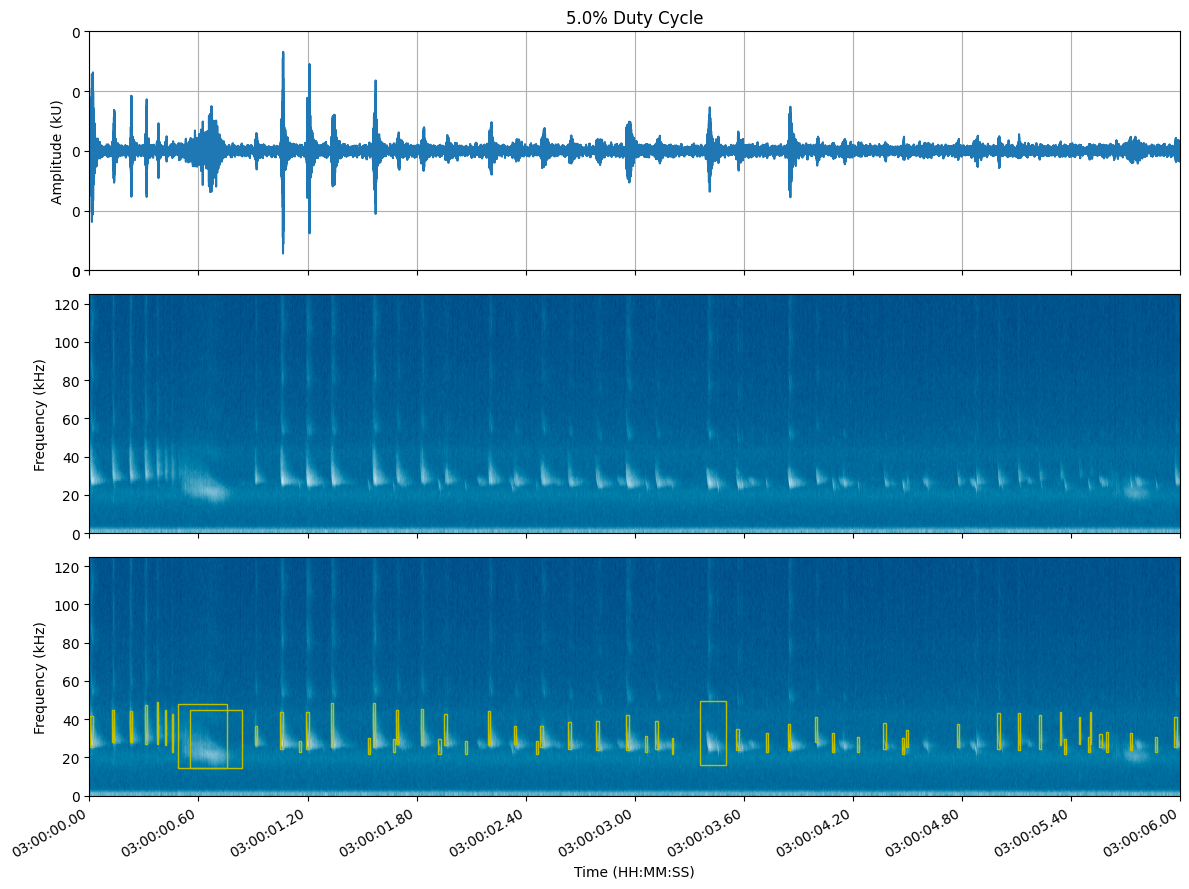

In [13]:
segmented_file_paths = pipeline.generate_segments(
        audio_file = cfg['audio_file'], 
        output_dir = cfg['tmp_dir'],
        start_time = cfg['start_time'],
        duration   = cfg['segment_duration'],
    )

pipeline._apply_models(cfg, segmented_file_paths)

audio_file = sf.SoundFile(cfg["audio_file"])
sr = audio_file.samplerate
audio = audio_file.read()

plt_msds('20210910_030000__5%DUTYCYCLE_1440secOFFSET.WAV', audio, sr, [0, 90], np.array([0, 6]), p_on=0.05)